In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import optimize
from sklearn.utils import resample
import xarray as xr

In [3]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({"font.family": "DejaVu Sans"})
cstyles = [i['color'] for i in plt.style.library['ggplot']['axes.prop_cycle']]
# from inches to cm
cm = 1/2.54

In [4]:
wbands_hs = np.arange(400,711, 5)

### SeaBass absorption distribution

In [5]:
# load a440 values from Craig et al. 2020
a440_range = pd.read_csv('data/a440_craig_et_al_2020.csv')

In [6]:
p_ternary = px.scatter_ternary(a440_range, a='aph', b='ag', c='ad', opacity=.5)

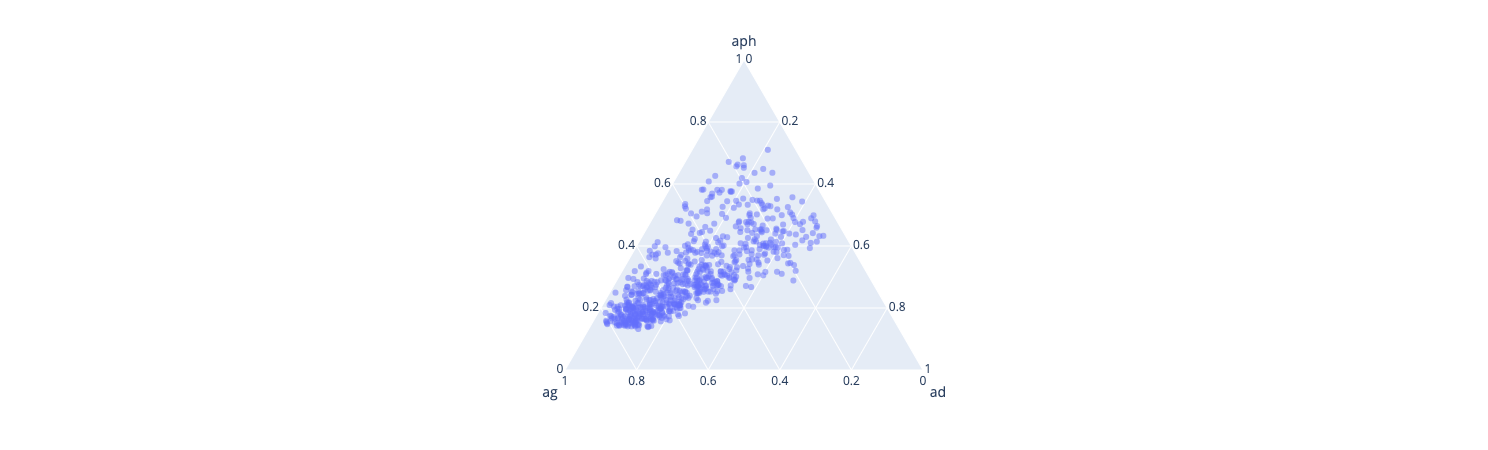

In [7]:
p_ternary.show()

### CDOM and detrital IOPs
See Babin et al. (2003)

Absorption:

In [8]:
np.random.seed(1)
# CDOM: mu = 0.0176, sd = 0.002
s_cdom = np.random.normal(.0176, .002, 1000)
# NAP: mu = 0.0123, sd = 0.0013
s_nap = np.random.normal(.0123, .0013, 1000)

Text(0.5, 0, 'slope NAP')

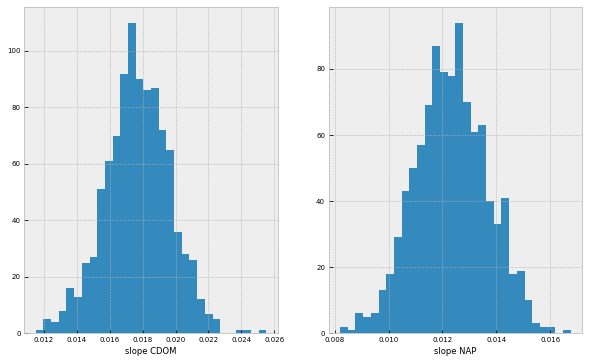

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(s_cdom, bins=30);
ax[0].set_xlabel('slope CDOM')
ax[1].hist(s_nap, bins=30);
ax[1].set_xlabel('slope NAP')

In [10]:
# spectral CDOM absorption
a_cdom = lambda ag_440: ag_440*np.exp(-np.random.choice(s_cdom)*(wbands_hs-440))
# spectral absorption by detrital matter
a_dm = lambda adm_440: adm_440*np.exp(-np.random.choice(s_nap)*(wbands_hs-440))

In [11]:
# parameter p1
p1 = lambda aph_440: .1+(.5*np.random.uniform(0,1)*aph_440)/(.05+aph_440)
# parameter p2
p2 = lambda aph_440: .3+(5.7*np.random.uniform(0,1)*aph_440)/(.02+aph_440)
# absorption detrital matter @ 440nm
adm_440 = lambda aph_440: p1(aph_440)*aph_440
# absorption cdom
ag_440 = lambda aph_440: p2(aph_440)*aph_440

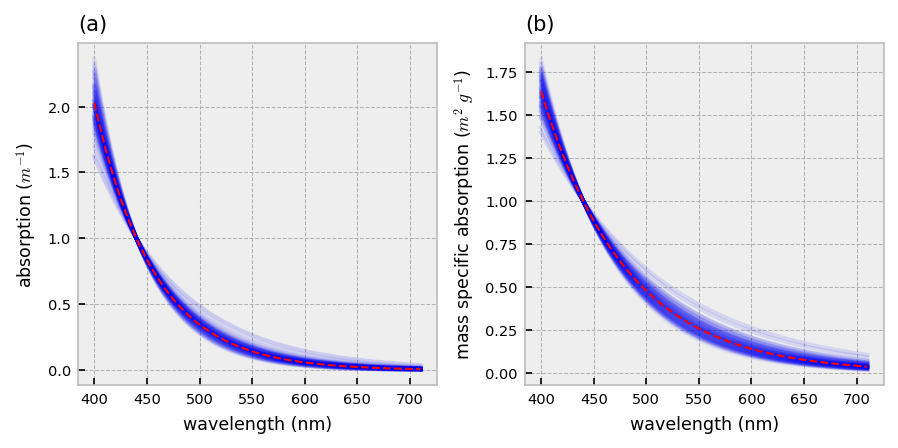

In [19]:
np.random.seed(1)
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)

[ax[0].plot(wbands_hs, a_cdom(1), color='blue', alpha=.05) for _ in range(100)];
ax[0].plot(wbands_hs, np.exp(-s_cdom.mean()*(wbands_hs-440)), linestyle='--', linewidth=1, color='red')
ax[0].set_xlabel('wavelength (nm)')
ax[0].set_ylabel('absorption ($m^{-1}$)')
ax[0].set_title('(a)', loc='left')

[ax[1].plot(wbands_hs, a_dm(1), color='blue', alpha=.05) for _ in range(100)];
ax[1].plot(wbands_hs, np.exp(-s_nap.mean()*(wbands_hs-440)), linestyle='--', linewidth=1, color='red')
ax[1].set_xlabel('wavelength (nm)')
ax[1].set_ylabel('mass specific absorption ($m^{2}\ g^{-1}$)')
ax[1].set_title('(b)', loc='left')

plt.tight_layout()
plt.savefig('cdom_dm_absorption.svg', format='svg')

Backscatter:

In [20]:
# parameter p4
p4 = lambda: np.random.uniform(.06,.6)
# detrital backscatter at 550 nm - assuming bb ratio of 1.4% 
bbdm_550 = lambda chl: .014*p4()*chl**.766
# parameter n2
n2 = lambda chl: -.5+(2+1.2*np.random.uniform(0,1))/(1+chl**.5)
# mass specific backscatter for detrital matter
bbdm_s = lambda chl: (550/wbands_hs)**n2(chl)
# spectral backscatte rfor detrital matter
bbdm = lambda chl: bbdm_550(chl)*bbdm_s(chl)
bbdm_2 = lambda adm_440, chl: bbdm_550(chl)*(550/wbands_hs)

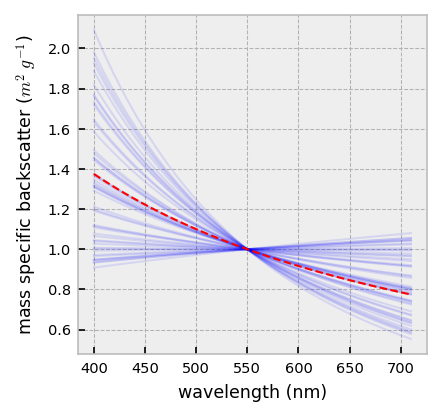

In [23]:
bbdm_star = np.array([bbdm_s(i) for i in np.logspace(-2,2)])
plt.figure(figsize=(3,3), dpi=150)
plt.plot(wbands_hs, bbdm_star.T, color='blue', alpha=.1, linewidth=1)
# assuming that parameter n2=1
plt.plot(wbands_hs, (550/wbands_hs), color='red', linestyle='--', linewidth=1)
# mean of all samples
#plt.plot(wbands_hs, bbdm_star.mean(axis=0), color='green', linestyle='--')
plt.xlabel('wavelength (nm)')
plt.ylabel('mass specific backscatter ($m^2\ g^{-1}$)')

plt.savefig('dm_backscatter.svg', format='svg')

### Phytoplankton IOPs

#### Spectral absorption

In [128]:
# siop for phytoplankton
aph_s = pd.read_csv('../hydropt/data/psc_absorption_se_uitz_2008.csv', index_col='wavelength')

In [129]:
aph_s = aph_s.reindex(np.unique(np.sort(np.concatenate([aph_s.index, wbands_hs]))))\
            .interpolate()\
            .loc[wbands_hs]

In [130]:
N = 100
# sample micro absorption
a_micro = pd.DataFrame(np.array([aph_s.micro+aph_s.micro_se*i for i in np.random.randn(N)]).T,
                       columns=[i for i in range(N)], index=aph_s.index)
# sample nano absorption
a_nano = pd.DataFrame(np.array([aph_s.nano+aph_s.nano_se*i for i in np.random.randn(N)]).T,
                       columns=[i for i in range(N)], index=aph_s.index)
# sample pico absorption
a_pico = pd.DataFrame(np.array([aph_s.pico+aph_s.pico_se*i for i in np.random.randn(N)]).T,
                       columns=[i for i in range(N)], index=aph_s.index)

In [131]:
olci_wbands = np.array([400,412.5,442.5,490,510,560,620,665,673.75,681.25,708.75])

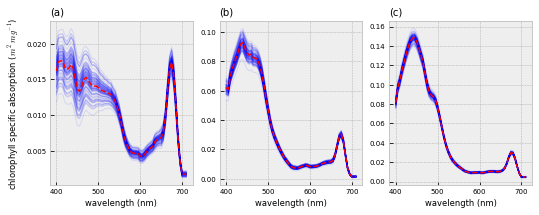

In [133]:
np.random.seed(1)
fig, ax = plt.subplots(1,3, figsize=(7.5, 3))

# micros
ax[0].plot(a_micro, alpha=.1, color='blue', linewidth=1);
ax[0].plot(a_micro.mean(axis=1), color='red', linestyle='--', linewidth=1.5);
ax[0].set_xlabel('wavelength (nm)')
ax[0].set_ylabel('chlorophyll specific absorption ($m^2\ mg^{-1}$)')
ax[0].set_title('(a)', loc='left')
# nanos
ax[1].plot(a_nano, color='blue', alpha=.1, linewidth=1);
ax[1].plot(a_nano.mean(axis=1), color='red', linestyle='--', linewidth=1.5);
ax[1].set_xlabel('wavelength (nm)')
ax[1].set_title('(b)', loc='left')
# picos
ax[2].plot(a_pico, color='blue', alpha=.1, linewidth=1);
ax[2].plot(a_pico.mean(axis=1), color='red', linestyle='--', linewidth=1.5);
ax[2].set_xlabel('wavelength (nm)')
ax[2].set_title('(c)', loc='left')

plt.tight_layout()

plt.savefig('psc_absorption.svg', format='svg')

#### Backscatter

In [134]:
np.random.seed(1)
# specific backscatter coefficient pico/nano
bb_star_pn = .0038
# standard error specific backscatter coefficient pico/nano
bb_star_pn_se = .0006/1.96
# spectral slope pico/nano
gamma_pn = 1.4
# standard error spectral slope
gamma_pn_se = .35/1.96

# specific backscatter coefficient micro
bb_star_m = .0004
# standard error specific backscatter coefficient pico/nano
bb_star_m_se = .0002/1.96
# spectral slope pico/nano
gamma_m = -.4
# standard error spectral slope
gamma_m_se = 1.1/1.96

# spectral specific backscatter 
def bbp(bb_star, gamma, waveb):
    return bb_star*(waveb/470)**-gamma

# create distribution for spectral backscatter coefficients
bbp_pn = pd.DataFrame(np.array([bbp(i*bb_star_pn_se+bb_star_pn, i*gamma_pn_se+gamma_pn, wbands_hs) for i in np.random.randn(N)]).T,
                      columns=[i for i in range(N)], index=wbands_hs)

bbp_m = pd.DataFrame(np.array([bbp(i*bb_star_m_se+bb_star_m, i*gamma_m_se+gamma_m, wbands_hs) for i in np.random.randn(N)]).T,
                     columns=[i for i in range(N)], index=wbands_hs)

# remove potential negative bb values for micros
bbp_m = bbp_m.loc[:, ~(bbp_m<0).any(0)]

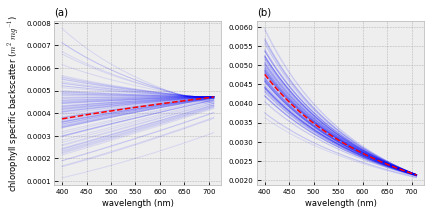

In [136]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
# micros
ax[0].plot(bbp_m, color='blue', alpha=.1, linewidth=1);
# ax[0].plot(bbp_m.mean(axis=1), color='green', linestyle='--');
ax[0].plot(wbands_hs, bbp(bb_star_m, gamma_m, wbands_hs), color='red', linestyle='--', linewidth=1.5)
ax[0].set_xlabel('wavelength (nm)')
ax[0].set_ylabel('chlorophyll specific backscatter ($m^2\ mg^{-1}$)')
ax[0].set_title('(a)', loc='left')
# pico-nanos
ax[1].plot(bbp_pn, color='blue', alpha=.1, linewidth=1);
# ax[1].plot(bbp_pn.mean(axis=1), color='green', linestyle='--');
ax[1].plot(wbands_hs, bbp(bb_star_pn, gamma_pn, wbands_hs), color='red', linestyle='--', linewidth=1.5)
ax[1].set_xlabel('wavelength (nm)')
ax[1].set_title('(b)', loc='left')

plt.tight_layout()

plt.savefig('psc_backscatter.svg', format='svg')

### Phytoplankton community structure

In [21]:
def psc_concentration(chl):
    #constants
    cm_pico_nano = 1.001
    s_pico_nano = 0.931
    cm_pico = 0.098
    s_pico = 8.271
    # calculate pico concentrations
    c_pico = cm_pico*(1-np.exp(-s_pico*chl))
    # calculate pico+nano concentrations
    c_pico_nano = cm_pico_nano*(1-np.exp(-s_pico_nano*chl))
    # calculate nano
    c_nano = c_pico_nano - c_pico
    # calculate micro 
    c_micro = chl - c_pico_nano
    # chl per size class
    c = pd.Series([c_pico, c_nano, c_micro], index=['pico','nano','micro'])
    
    return c

In [22]:
def add_lognormal_noise(x, noise=1):
    y = pd.Series(
        [np.random.lognormal(np.log(i), noise) for i in x], index=['pico','nano','micro'])  
    # recalculate total chlorophyll
    y['chl'] = y.sum()
    
    return y

In [23]:
psc_data = pd.DataFrame({
    'chl': np.logspace(-2, 1.5, 500)
})

In [24]:
psc_data =  psc_data.apply(lambda x: add_lognormal_noise(psc_concentration(x.chl)), axis=1)

(0.011, 656.2956497529849)

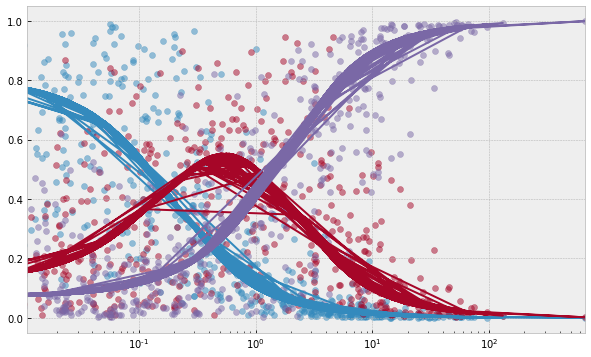

In [25]:
plt.figure(figsize=(10,6))
psc_model = psc_concentration(psc_data.chl)

# picos
plt.scatter(psc_data.chl, psc_data.pico/psc_data.chl, alpha=.5)
plt.plot(psc_data.chl, psc_model.pico/psc_data.chl)
#nanos
plt.scatter(psc_data.chl, psc_data.nano/psc_data.chl, alpha=.5)
plt.plot(psc_data.chl, psc_model.nano/psc_data.chl)
#micros
plt.scatter(psc_data.chl, psc_data.micro/psc_data.chl, alpha=.5)
plt.plot(psc_data.chl, psc_model.micro/psc_data.chl)

plt.xscale('log')
plt.xlim(.011, psc_data.chl.max())

### Synthetic IOP dataset
Here we use *Lee et al. Models, parameters, and approaches that used to generate wide
range of absorption and backscattering spectra, IOCCG* to generate plausible IOP ranges

In [26]:
def make_dataset(chl):    
    chl_p, chl_n, chl_m = chl.pico, chl.nano, chl.micro
    # total chlorophyll
    t_chl = ['pico', 'nano', 'micro']
    # fill array with nans according to IOP dimensions
    null_array = np.full((2, len(wbands_hs)), np.nan)
    # init. xarray dataset
    ds = xr.Dataset(
        {
            'iops': (['comp', 'iop', 'wavelength'],
                     np.repeat(null_array[None,:], 5, axis=0)),
            'conc': (['comp'], np.array([chl_p, chl_n, chl_m, np.nan, np.nan]))
        },
        coords={
            'no': np.array([chl.name]),
            'wavelength': wbands_hs,
            'comp': ['pico', 'nano', 'micro', 'cdom', 'dm'],
            'iop': ['a', 'bb']
        })
    # picos
    ds.iops.loc['pico'] = chl_p * np.array([
        a_pico.sample(axis=1).values[:,0],
        bbp_pn.sample(axis=1).values[:,0]])   
    # nanos
    ds.iops.loc['nano'] = chl_n * np.array([
        a_nano.sample(axis=1).values[:,0],
        bbp_pn.sample(axis=1).values[:,0]])
    # micros
    ds.iops.loc['micro'] = chl_m * np.array([
        a_micro.sample(axis=1).values[:,0],
        bbp_m.sample(axis=1).values[:,0]])
    # calculate aph @ 440 nm
    aph_440 = ds.iops.sel(wavelength=440, iop='a', comp=t_chl).sum().values
    # calculate detrital IOPs
#     _adm_440 = adm_440(aph_440)
#     ds.iops.loc['dm'] = np.array([a_dm(_adm_440), bbdm_2(_adm_440, chl.sum())])
    ds.iops.loc['dm'] = np.array([a_dm(adm_440(aph_440)), bbdm(chl.sum())])
    # calculate CDOM absorption
    ds.iops.loc['cdom'] = np.array([a_cdom(ag_440(aph_440)), np.zeros(len(wbands_hs))])
    
    return ds

In [27]:
ds = psc_data.apply(make_dataset, axis=1)

In [28]:
ds = xr.concat(ds, dim='no')

Remove IOP simulations where total absorption (at 440 nm) exceeds minimum and maximum absorption values used for HYDROPT construction.

In [29]:
# filter a440 (excl. water) that exceed HYDROPT min and max a440 values
a440_max = 13.76
a440_min = .008
# condition
sel = (ds.iops.sel(iop='a', wavelength=440).sum(axis=1) > a440_min)\
    & (ds.iops.sel(iop='a', wavelength=440).sum(axis=1) < a440_max)
ds = ds.where(sel, drop=True)

In [30]:
# save to netcdf
ds.to_netcdf('data/psc_rrs_iop.nc')

In [31]:
ds_df = ds.iops.sel(iop='a', wavelength=440).to_dataframe().iops.unstack()

In [32]:
ds_df['chl'] = ds_df.apply(lambda x: x.pico+x.nano+x.micro, axis=1)

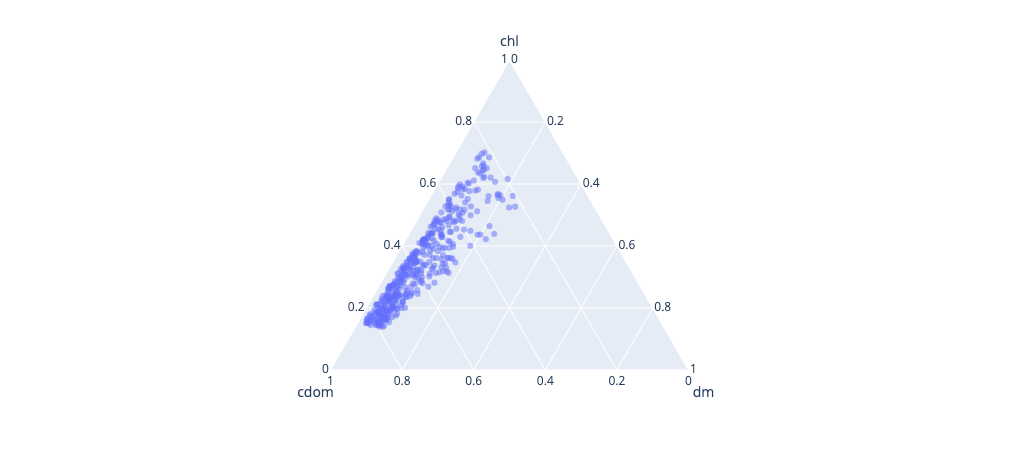

In [33]:
px.scatter_ternary(ds_df, a='chl', b='cdom', c='dm', opacity=.5)

In [32]:
ioccg = pd.read_csv('/Users/tadzio/Documents/code_repo/hydropt_4_sent3/data/external/IOCCG_validate.csv', sep=';')

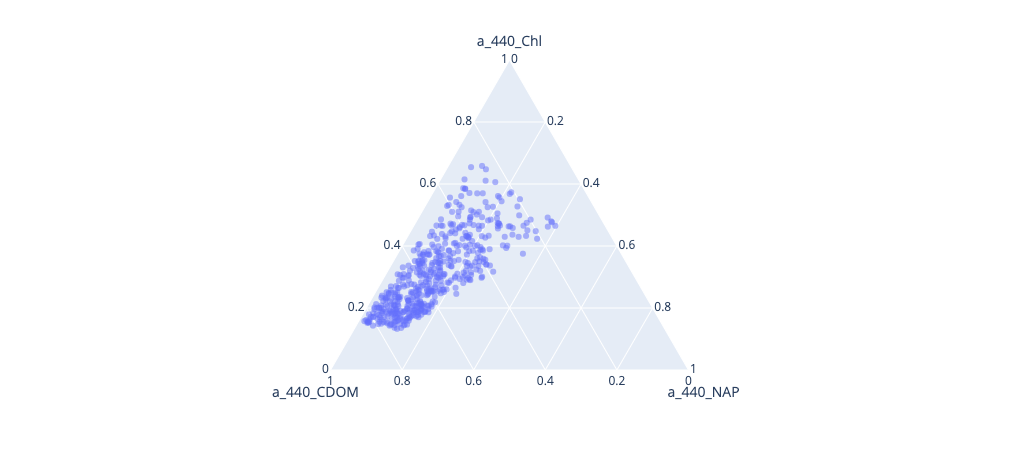

In [33]:
px.scatter_ternary(ioccg, a='a_440_Chl', b='a_440_CDOM', c='a_440_NAP', opacity=.5)

In [68]:
# read nomad dataset
nomad = pd.read_csv('/Users/tadzio/Downloads/nasa_nomad.csv')\
            .replace(-999, value=np.nan)

In [69]:
# diagnostic pigments
dp = ['fuco', 'perid', 'allo', 'but-fuco', 'hex-fuco', 'chl_b', 'zea']
# absorption @ 443 nm
a_443 = ['ad443', 'ap443', 'ag443']

In [70]:
nomad = nomad[dp+['chl_a']]\
        .dropna()

In [71]:
def dpa(x):
    micro = 1.41*x['fuco']+1.41*x['perid']
    nano = .6*x['allo']+.35*x['but-fuco']+1.27*x['hex-fuco']
    pico = .86*x['zea']+1.01*x['chl_b']
    tot = micro+nano+pico
    
    return pd.Series([micro/tot, nano/tot, pico/tot])

In [72]:
nomad[['f_micro', 'f_nano', 'f_pico']] = nomad.apply(dpa, axis=1)

In [97]:
pico_chl = lambda x: 2.66*(1-np.exp(-.087*x))
nano_chl = lambda x: 3.91*(1-np.exp(-.11*x)) - pico_chl(x)
micro_chl = lambda x: x-pico_chl(x)-nano_chl(x)

(0.0001, 100.0)

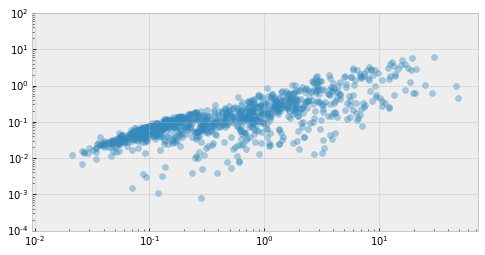

In [264]:
chl_range = np.logspace(-2,2)
# plt.scatter(nomad.chl_a, nomad.f_micro*nomad.chl_a, alpha=.4)
# plt.scatter(nomad.chl_a, (nomad.f_nano+nomad.f_pico)*nomad.chl_a, alpha=.4)
plt.scatter(nomad.chl_a, nomad.f_pico*nomad.chl_a, alpha=.4)
# plt.plot(chl_range, micro_chl(chl_range))
# plt.plot(chl_range, nano_chl(chl_range)+pico_chl(chl_range))
# plt.plot(chl_range, pico_chl(chl_range))


plt.loglog()
# plt.xscale('log')
plt.ylim([1E-4,1E2])

In [115]:
optimize.curve_fit(lambda chl,c,s: c*(1-np.exp(-s*chl)), nomad.chl_a, (nomad.f_nano+nomad.f_pico)*nomad.chl_a)

(array([3.91059854, 0.1095532 ]), array([[ 0.05625367, -0.0023473 ],
        [-0.0023473 ,  0.00011686]]))